## Overview
This tutorial has been prepared by Alex Bonnet, ML Solutions Engineer @ Encord - you might also be interested in checking out our open-source framework for computer vision model testing, evaluation, and validation that you can find here https://github.com/encord-team/encord-active).

This is the notebook which implements the steps discussed in this blog post: https://encord.com/blog/learn-how-to-fine-tune-the-segment-anything-model-sam/

The aim is to take Segment Anything Model and fine tune it to a specific application. We are going to be using the stamp verification dataset https://www.kaggle.com/datasets/rtatman/stamp-verification-staver-dataset since it has data SAM is unlikely to have seen (scans of invoices with stamps), has precise ground truth segmentation masks and also has bounding boxes which we can use as prompts to SAM.

## Set up

**Action Required:** Place your kaggle.json file into the files in the notebook workspace. More info here https://github.com/Kaggle/kaggle-api#api-credentials

In [1]:
import sys
import os
sys.path.insert(0, os.path.dirname(os.path.abspath('../src')))

In [2]:
data_path = "../images" #"../data/raw/"

In [2]:
! pip install torch torchvision &> /dev/null
! pip install opencv-python pycocotools matplotlib onnxruntime onnx &> /dev/null
! pip install git+https://github.com/facebookresearch/segment-anything.git &> /dev/null
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth &> /dev/null

In [3]:
from pathlib import Path
import numpy as np
import cv2
import re
import json
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

import torch
from torch import nn
import torch.onnx as onnx
import torchvision.models as models
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.nn.functional import threshold, normalize

from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.onnx import SamOnnxModel
from segment_anything.utils.transforms import ResizeLongestSide

from collections import defaultdict

import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

from statistics import mean

from tqdm import tqdm

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


ImportError: dlopen(/opt/anaconda3/lib/python3.9/site-packages/torch/_C.cpython-39-darwin.so, 0x0002): Library not loaded: '@loader_path/libshm.dylib'
  Referenced from: '/opt/anaconda3/lib/python3.9/site-packages/torch/lib/libtorch_python.dylib'
  Reason: tried: '/opt/anaconda3/lib/python3.9/site-packages/torch/lib/libshm.dylib' (no such file), '/usr/local/lib/libshm.dylib' (no such file), '/usr/lib/libshm.dylib' (no such file)

## Preprocess data

We extract the bounding box coordinates which will be used to feed into SAM as prompts.

In [3]:
#path_to_images = '/Users/capelo/Desktop/constructor/final_project/fine_tune_sam/UAVVaste/branch_UAVVaste/UAVVaste/images/'



# List all JPEG image names in the directory
path_to_images = '/content/drive/MyDrive/Data/UAVVaste/images/'
jpg_image_names = sorted([(path_to_images + filename) for filename in os.listdir(path_to_images) if filename.endswith(".jpg")])

#path_to_lbox = '../data/raw/labelbox_masks/training_litterboxes_jpeg/'
#jpg_lbox_names = sorted([(path_to_lbox + filename) for filename in os.listdir(path_to_lbox) if filename.endswith(".jpg")])

#path_to_mask = '../data/raw/labelbox_masks/training_masks_jpeg/'
#jpg_mask_names = sorted([(path_to_mask + filename) for filename in os.listdir(path_to_mask) if filename.endswith(".jpg")])

##change path
path_to_npz_mask = '/Users/capelo/Desktop/constructor/final_project/fine_tune_sam/UAVVaste/branch_UAVVaste/UAVVaste/masks/pixel_zipped/'
npz_mask_names = sorted([(path_to_npz_mask + filename) for filename in os.listdir(path_to_npz_mask) if filename.endswith(".npz")])

##change path for bboxes
path_to_npz_mask = '/Users/capelo/Desktop/constructor/final_project/fine_tune_sam/UAVVaste/branch_UAVVaste/UAVVaste/bb_zipped/'
npz_mask_names = sorted([(path_to_npz_mask + filename) for filename in os.listdir(path_to_npz_mask) if filename.endswith(".npz")])



NameError: ignored

In [ ]:
bbox_coords = {}

for f in jpg_lbox_names:
    k = re.sub("_pmask_bw", "", re.findall("\/([^/]+)\.", f)[0])
    im = cv2.imread(f)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    L = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        L.append([x, y, x + w, y + h])
    bbox_coords[k] = np.array(L)

In [ ]:
ground_truth_masks = {}
for j, f in enumerate(npz_mask_names):
    k = re.findall("/([^/]+).", f)[0]
    pre_mask = np.load(f)
    ground_truth_masks[k] = pre_mask["arr_0"]

In [ ]:
#### change for bounding boxes
ground_truth_masks = {}
for j, f in enumerate(npz_mask_names):
    k = re.findall("/([^/]+).", f)[0]
    pre_mask = np.load(f)
    ground_truth_masks[k] = pre_mask["arr_0"]

In [ ]:
df_bounding_boxes_from_polygons = pd.read_csv("../data/process/labelbox_trainset_normalized_bounding_boxes_from_polygons.csv")

In [ ]:
df_bounding_boxes_from_polygons.head(5)

,filename,x1,y1,x2,y2,width,height,img_width,img_height
0,labelbox_masks/images_and_bboxes/2014_06_02_04...,0.397081,0.567750,0.475467,0.615494,0.078386,0.047744,640,480
1,labelbox_masks/images_and_bboxes/2014_06_02_04...,0.473123,0.570312,0.513619,0.620181,0.040495,0.049869,640,480
2,labelbox_masks/images_and_bboxes/2014_06_02_04...,0.498969,0.560633,0.588553,0.620856,0.089584,0.060223,640,480
3,labelbox_masks/images_and_bboxes/2014_08_25_04...,0.395973,0.209529,0.445913,0.272043,0.049940,0.062514,4608,3456
4,labelbox_masks/images_and_bboxes/2014_08_25_04...,0.540747,0.621276,0.611060,0.809548,0.070312,0.188271,4608,3456


In [ ]:
bbox_coords = get_numpy_arrays(df_bounding_boxes_from_polygons)

In [ ]:
bbox_coords.keys()

dict_keys(['1648793803779', '1648809310259', '1648809310559', '1648905626810', '1649050020247', '1649050746608', '1649064538371', '1649233279533', '1649330331610', '1649338164670', '1649395279745', '1649398621181', '1649409215680', '1649416608327', '1649417898358', '1649422865937', '1649432968550', '1649485789081', '1649572867951', '1649653550409', '1649655207148', '1649665962837', '1649674878327', '1649680689791', '1649680959011', '1649682365069', '1649740862970', '1649742800989', '1649745535517', '1649752617113', '1649763895295', '1649828799722', '1649830833449', '1649832799037', '1649833722798', '1649843024797', '1649850669675', '1649853869911', '1649914729991', '1649916495896', '1649916542853', '1649918366825', '1649921845445', '1649923544348', '1649924029310', '1649924031200', '1649931385263', '1649934898895', '1649946056919', '1651381708164', '1651405614036', '1651427492305', '1651471137561', '1651471855651', '1651473358448', '1651734273729', '1651821840814', '1652332693534', '16

In [ ]:
bbox_coords['1648793803779']

array([[261.597, 572.109, 331.597, 620.359],
       [681.905, 530.431, 712.072, 542.598]])

We extract the ground truth segmentation masks

In [ ]:
ground_truth_masks = {}

for f in jpg_mask_names:
    k = re.sub("_pmask_bw", "", re.findall("\/([^/]+)\.", f)[0])
    im = cv2.imread(f)
    gt_grayscale = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    ground_truth_masks[k] = (gt_grayscale == 0)


In [ ]:
import cv2

ground_truth_masks = {}

for f in jpg_mask_names:
    k = re.sub("_pmask_bw", "", re.findall("\/([^/]+)\.", f)[0])
    im = cv2.imread(f)
    gt_grayscale = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    ground_truth_masks[k] = (gt_grayscale == 0)

In [ ]:
ground_truth_masks.keys()

dict_keys(['1648793803779', '1648809310259', '1648809310559', '1648905626810', '1649050020247', '1649050746608', '1649064538371', '1649233279533', '1649330331610', '1649338164670', '1649395279745', '1649398621181', '1649409215680', '1649416608327', '1649417898358', '1649422865937', '1649432968550', '1649485789081', '1649572867951', '1649653550409', '1649655207148', '1649665962837', '1649674878327', '1649680689791', '1649680959011', '1649682365069', '1649740862970', '1649742800989', '1649745535517', '1649752617113', '1649763895295', '1649828799722', '1649830833449', '1649832799037', '1649833722798', '1649843024797', '1649850669675', '1649853869911', '1649914729991', '1649916495896', '1649916542853', '1649918366825', '1649921845445', '1649923544348', '1649924029310', '1649924031200', '1649931385263', '1649934898895', '1649946056919', '1651381708164', '1651405614036', '1651427492305', '1651471137561', '1651471855651', '1651473358448', '1651734273729', '1651821840814', '1652332693534', '16

In [ ]:
ground_truth_masks["1648793803779"]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
ground_truth_masks = {}

for f in npz_mask_names:
    k = re.findall("\/([^/]+)\.", f)[0]
    ground_truth_masks[k] = np.load(f)["arr_0"]

In [ ]:
ground_truth_masks["1648793803779"].shape

(2, 1, 1080, 1920)

## Take a look at the images, the bounding box prompts and the ground truth segmentation masks

In [ ]:
# Helper functions provided in https://github.com/facebookresearch/segment-anything/blob/9e8f1309c94f1128a6e5c047a10fdcb02fc8d651/notebooks/predictor_example.ipynb
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

We can see here that the ground truth mask is extremely tight which will be good for calculating an accurate loss.
The bounding box overlaid will be a good prompt.

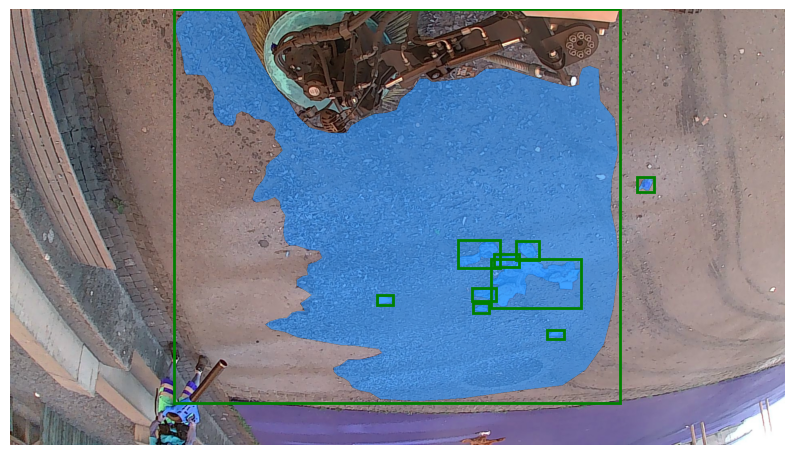

In [ ]:
name =  '1652856600171' # '1649398621181' # '1648793803779' #

image = cv2.imread(f'../data/raw/labelbox_masks/images_and_bboxes/{name}.jpg')

plt.figure(figsize=(10, 10))
plt.imshow(image)

for bbox_coord in bbox_coords[name]:
    show_box(bbox_coord, plt.gca())

for mask in ground_truth_masks[name]:
    show_mask(mask, plt.gca())

plt.axis('off')
plt.show()

In [ ]:
bbox_coords[name].shape

(10, 4)

In [ ]:
ground_truth_masks[name].shape

(10, 1, 1080, 1920)

## Prepare Fine Tuning

In [ ]:
model_type = 'vit_b'
checkpoint = '../data/SAM_checkpoints/sam_vit_b_01ec64.pth'
device = 'cpu'

In [ ]:
sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)
sam_model.train();

We convert the input images into a format SAM's internal functions expect.

In [ ]:
# Preprocess the images
transformed_data = defaultdict(dict)

for f in jpg_image_names:
    k = re.findall("\/([^/]+)\.", f)[0]
    im = cv2.imread(f)
    image = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    transform = ResizeLongestSide(sam_model.image_encoder.img_size)
    input_image = transform.apply_image(image) #image resizing transformation to the image

    #converts the input_image NumPy array to a PyTorch tensor using torch.as_tensor()
    input_image_torch = torch.as_tensor(input_image, device=device)
    transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

    input_image = sam_model.preprocess(transformed_image)

    original_image_size = image.shape[:2]
    input_size = tuple(transformed_image.shape[-2:])

    transformed_data[k]['image'] = input_image
    transformed_data[k]['input_size'] = input_size
    transformed_data[k]['original_image_size'] = original_image_size

In [ ]:
transformed_data[k]['image']

tensor([[[[ 0.6392,  0.5022,  0.4508,  ..., -0.3369, -0.4739, -0.5424],
          [ 0.7077,  0.6392,  0.6392,  ..., -0.4739, -0.5938, -0.6794],
          [ 0.6392,  0.5536,  0.5364,  ..., -0.5424, -0.6623, -0.7308],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.6954,  0.6078,  0.5903,  ..., -0.2325, -0.3550, -0.4251],
          [ 0.7479,  0.7304,  0.7479,  ..., -0.3375, -0.4601, -0.5476],
          [ 0.7129,  0.6429,  0.6429,  ..., -0.4251, -0.5301, -0.6176],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.9494,  0.8448,  0.8099,  ...,  0.1128, -0.0441, -0.1138],
          [ 1.0017,  0.9668,  

In [ ]:
transformed_data[k]['input_size']

(768, 1024)

In [ ]:
transformed_data[k]['original_image_size']

(3456, 4608)

In [ ]:
transformed_data = {key: transformed_data[key] for key in ground_truth_masks.keys()}

In [ ]:
bbox_keys = set(bbox_coords.keys())
gt_mask_keys = set(ground_truth_masks.keys())
transformed_data_keys = set(transformed_data.keys())

# Check if bbox_coords and ground_truth_masks have matching keys with transformed_data
matching_keys = bbox_keys.intersection(gt_mask_keys).intersection(transformed_data_keys)

# Check if the number of matching keys is equal to the total number of keys in transformed_data
keys_match = len(matching_keys) == len(transformed_data_keys)

# Print the result
print("Image keys match:", keys_match)

Image keys match: True


In [ ]:
# Set up the optimizer
lr = 1e-4
wd = 0 # no weight decay is applied(no regularization technique that adds a penalty term to the loss function)
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=wd)

# Set up the Mean Squared Error (MSE) loss function to calculate the mean squared difference between the predicted and target values
loss_fn = torch.nn.MSELoss()

# get the keys by converting them into list
keys = list(bbox_coords.keys())

In [ ]:
ground_truth_masks[name].shape

(10, 1, 1080, 1920)

In [ ]:
bbox_coords[name]

array([[ 1.197432e+03,  6.052980e+02,  1.259766e+03,  6.386310e+02],
       [ 9.090160e+02,  7.077160e+02,  9.495160e+02,  7.332160e+02],
       [ 1.108266e+03,  5.726310e+02,  1.212266e+03,  6.399650e+02],
       [ 1.253266e+03,  5.741310e+02,  1.308932e+03,  6.201310e+02],
       [ 1.192266e+03,  6.192150e+02,  1.414516e+03,  7.399660e+02],
       [ 1.147349e+03,  7.288830e+02,  1.186349e+03,  7.525500e+02],
       [ 1.144932e+03,  6.907160e+02,  1.202766e+03,  7.216330e+02],
       [ 1.330307e+03,  7.940920e+02,  1.372432e+03,  8.168420e+02],
       [ 1.553974e+03,  4.155450e+02,  1.595141e+03,  4.522120e+02],
       [ 4.054410e+02, -1.700000e-02,  1.509781e+03,  9.745630e+02]])

## Run fine tuning

This is the main training loop.

Improvements to be made include batching and moving the computation of the image and prompt embeddings outside the loop since we are not tuning these parts of the model, this will speed up training as we should not recompute the embeddings during each epoch. Sometimes the optimizer gets lost in the parameter space and the loss function blows up. Restarting from scratch (including running all cells below 'Prepare Fine Tuning' in order to start with default weights again) will solve this.

In a production implementation a better choice of optimiser/loss function will certainly help.

In [ ]:
num_epochs = 100
losses = []

for epoch in range(num_epochs):
  epoch_losses = []
  # Just train on the first 20 examples
  for i, k in enumerate(keys):
    print(k)
    if i > 20:
       break

    input_image = transformed_data[k]['image'].to(device)
    input_size = transformed_data[k]['input_size']
    original_image_size = transformed_data[k]['original_image_size']

    # No grad here as we don't want to optimise the encoders
    with torch.no_grad():
        image_embedding = sam_model.image_encoder(input_image)

        # Here we should be able to use the bbxes
        # created with the numpy_array function
        prompt_box = bbox_coords[k]
        prompt_box = np.array(prompt_box)  # Convert prompt_box to NumPy array
        box = transform.apply_boxes(prompt_box, original_image_size)
        box_torch = torch.as_tensor(box, dtype=torch.float, device=device)

        # print(box_torch.shape)
        # box_torch = box_torch[None, :]
        # print(box_torch.shape)

        sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
          points=None,
          boxes=box_torch,
          masks=None,
      )
    low_res_masks, iou_predictions = sam_model.mask_decoder(
      image_embeddings=image_embedding,
      image_pe=sam_model.prompt_encoder.get_dense_pe(),
      sparse_prompt_embeddings=sparse_embeddings,
      dense_prompt_embeddings=dense_embeddings,
      multimask_output=False,
    )
    upscaled_masks = sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
    binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))

    # gt_mask_resized = torch.from_numpy(np.resize(ground_truth_masks[k], (1, 1, ground_truth_masks[k].shape[0], ground_truth_masks[k].shape[1]))).to(device)
    gt_mask_resized = torch.from_numpy(ground_truth_masks[k]).to(device)
    # gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)
    gt_binary_mask = torch.as_tensor(gt_mask_resized, dtype=torch.float32)

    loss = loss_fn(binary_mask, gt_binary_mask)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_losses.append(loss.item())
  losses.append(epoch_losses)
  print(f'EPOCH: {epoch}')
  print(f'Mean loss: {mean(epoch_losses)}')

1648793803779
1648809310259
1648809310559
1648905626810
1649050020247
1649050746608
1649064538371
1649233279533
1649330331610
1649338164670
1649395279745
1649398621181
1649409215680
1649416608327
1649417898358
1649422865937
1649432968550
1649485789081
1649572867951
1649653550409
1649655207148
1649665962837
EPOCH: 0
Mean loss: 0.0010662444111360293
1648793803779
1648809310259
1648809310559
1648905626810
1649050020247
1649050746608
1649064538371
1649233279533
1649330331610
1649338164670
1649395279745
1649398621181
1649409215680
1649416608327
1649417898358
1649422865937
1649432968550
1649485789081
1649572867951
1649653550409
1649655207148
1649665962837
EPOCH: 1
Mean loss: 0.0010654856814653613
1648793803779
1648809310259
1648809310559
1648905626810
1649050020247
1649050746608
1649064538371
1649233279533
1649330331610
1649338164670
1649395279745
1649398621181


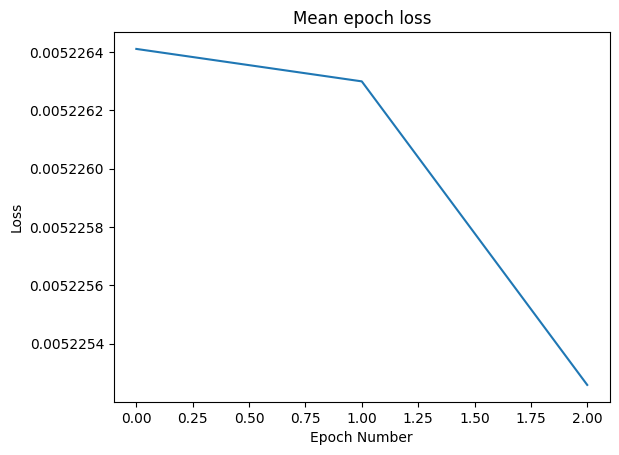

In [ ]:
mean_losses = [mean(x) for x in losses]
mean_losses

plt.plot(list(range(len(mean_losses))), mean_losses)
plt.title('Mean epoch loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')

plt.show()

## We can compare our tuned model to the original model

In [ ]:
# Load up the model with default weights
sam_model_orig = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model_orig.to(device);

In [ ]:
# Set up predictors for both tuned and original models
from segment_anything import sam_model_registry, SamPredictor
predictor_tuned = SamPredictor(sam_model)
predictor_original = SamPredictor(sam_model_orig)

In [ ]:
# The model has not seen keys[21] (or keys[20]) since we only trained on keys[:20]
import cv2

try:
    k = keys[21]
    image = cv2.imread(f'/content/200dpi_small/scans/{k}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
except IndexError:
    print("Index out of range. Please check the length of the 'keys' list.")


#k = keys[21]
#image = cv2.imread(f'/content/200dpi_small/scans/{k}.png')
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor_tuned.set_image(image)
predictor_original.set_image(image)

input_bbox = np.array(bbox_coords[k])

masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

masks_orig, _, _ = predictor_original.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

Index out of range. Please check the length of the 'keys' list.


We can see here that the tuned model is starting to ignore the whitespace between the words, which is what the ground truths show. With further training, more data and further hyperparameter tuning we will be able to improve this result.

If the image does not render due to size limitations, you can view it here https://drive.google.com/file/d/1ip5aryaxcp8JcEaZubL76oOM6srVzKsc/view?usp=sharing .

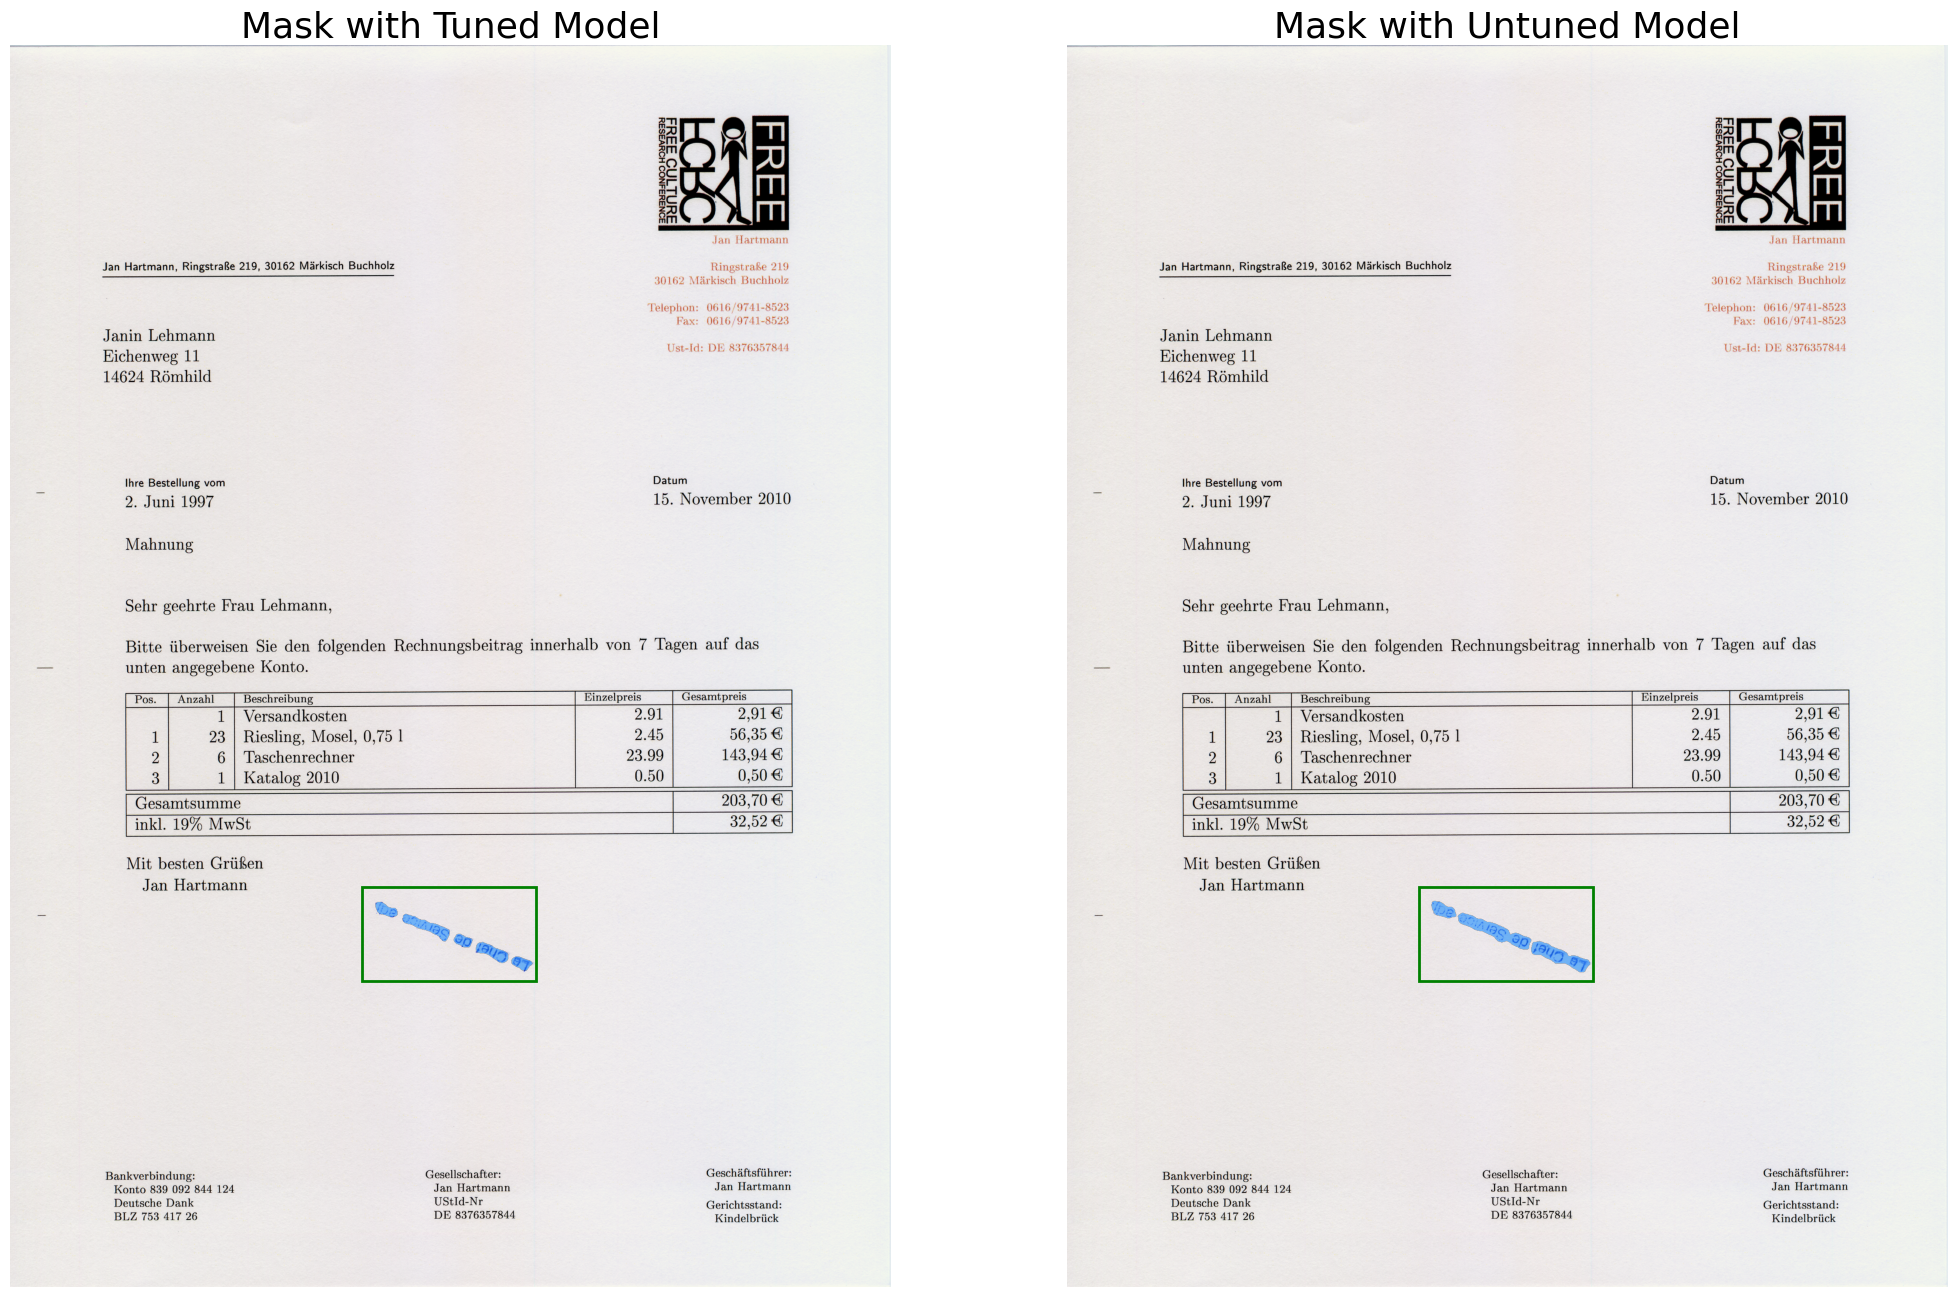

In [ ]:
%matplotlib inline
_, axs = plt.subplots(1, 2, figsize=(25, 25))


axs[0].imshow(image)
show_mask(masks_tuned, axs[0])
show_box(input_bbox, axs[0])
axs[0].set_title('Mask with Tuned Model', fontsize=26)
axs[0].axis('off')


axs[1].imshow(image)
show_mask(masks_orig, axs[1])
show_box(input_bbox, axs[1])
axs[1].set_title('Mask with Untuned Model', fontsize=26)
axs[1].axis('off')

plt.show()